In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score

2024-12-18 23:18:03.784638: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 23:18:03.959104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734535084.030658  122139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734535084.049349  122139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 23:18:04.250124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# 讀取 Kidney 資料
data_dir = './Kidney Cancer'
labels = ['kidney_normal', 'kidney_tumor']

# 參數設定
image_size = (128, 128)
random_state = 42
batch_size = 32
epochs = 50
learning_rate = 0.0001

In [3]:
X, y = [], []

for label in labels:
    folder_path = os.path.join(data_dir, label)

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        X.append(img)
        y.append(label)

X, y = np.array(X), np.array(y)

print(X.shape, y.shape)

(10000, 128, 128, 3) (10000,)


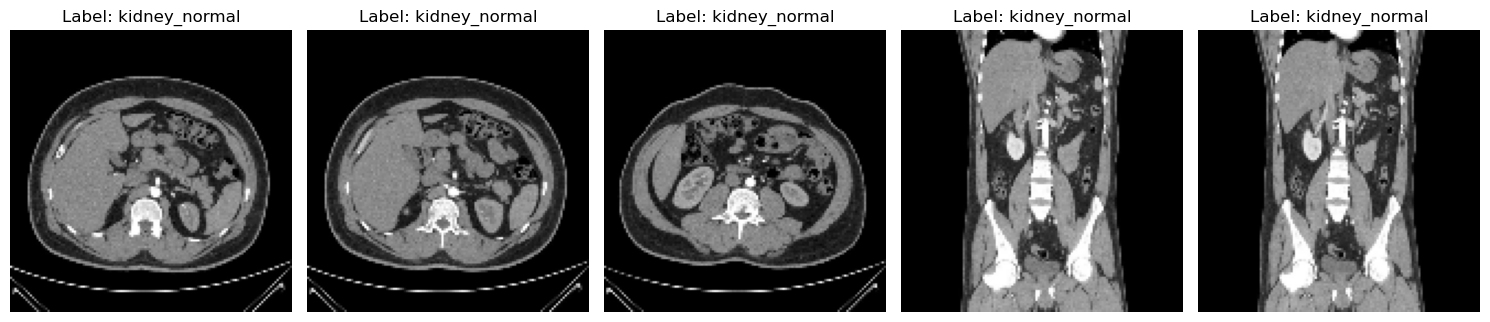

In [4]:
# label_map = {0: 'kidney_normal', 1: 'kidney_tumor'}
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axes[i].imshow(X[i])
    # axes[i].set_title(f"Label: {label_map[y[i]]}")
    axes[i].set_title(f"Label: {y[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# 正規化
X = X / 255.0

y = np.where(y == 'kidney_normal', 0, 1)

# 進行 one-hot 編碼
y = to_categorical(y, num_classes=2)

In [6]:
X, y = shuffle(X,y, random_state=random_state)

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

print(f"Train samples: {X_train.shape}")
print(f"Validation samples: {X_val.shape}")
print(f"Test samples: {X_test.shape}")

Train samples: (7000, 128, 128, 3)
Validation samples: (1500, 128, 128, 3)
Test samples: (1500, 128, 128, 3)


In [7]:
# 數據增強
# train_datagen = ImageDataGenerator(
#     rotation_range=5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True
# )
#
# val_test_datagen = ImageDataGenerator()
#
# train_generator = train_datagen.flow(
#     X_train, y_train,
#     batch_size=batch_size,
#     shuffle=True
# )
#
# val_generator = val_test_datagen.flow(
#     X_val, y_val,
#     batch_size=batch_size,
#     shuffle=False
# )
#
# test_generator = val_test_datagen.flow(
#     X_test, y_test,
#     batch_size=batch_size,
#     shuffle=False
# )
#
# val_images, val_labels = next(val_generator)
# print(f"Validation images batch shape: {val_images.shape}")
# print(f"Validation labels batch shape: {val_labels.shape}")
#
# test_images, test_labels = next(test_generator)
# print(f"Test images batch shape: {test_images.shape}")
# print(f"Test labels batch shape: {test_labels.shape}")

Validation images batch shape: (32, 128, 128, 3)
Validation labels batch shape: (32, 2)
Test images batch shape: (32, 128, 128, 3)
Test labels batch shape: (32, 2)


In [9]:
# 定義 ResNet50 模型
def ResNet50Model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(64)(x)
    # x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    # x = Dense(32, kernel_regularizer=l2(0.001))(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(2, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
# 初始化模型
input_shape = (image_size[0], image_size[1], 3)
model = ResNet50Model(input_shape)

I0000 00:00:1734535169.000103  122139 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [ ]:
# 檢視模型架構
model.summary()

In [10]:
# 訓練模型
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=epochs,
#     batch_size=batch_size
# )

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/50


I0000 00:00:1734535188.761703  122418 service.cc:148] XLA service 0x7f6ce4001680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734535188.762096  122418 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-18 23:19:48.889118: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734535189.677492  122418 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-18 23:19:50.556559: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_

 12/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5517 - loss: 0.7126

I0000 00:00:1734535192.533909  122418 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


216/219 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5148 - loss: 0.7057

2024-12-18 23:19:56.877399: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[24,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-18 23:19:57.117881: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[24,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,128,16,16]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5149 - loss: 0.7056

2024-12-18 23:20:03.253674: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[28,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-18 23:20:03.449198: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[28,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,128,16,16]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.5150 - loss: 0.7056 - val_accuracy: 0.7913 - val_loss: 0.6804
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5608 - loss: 0.6858 - val_accuracy: 0.6540 - val_loss: 0.6637
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6275 - loss: 0.6650 - val_accuracy: 0.7487 - val_loss: 0.6417
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6655 - loss: 0.6406 - val_accuracy: 0.7187 - val_loss: 0.6052
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7112 - loss: 0.6056 - val_accuracy: 0.7707 - val_loss: 0.5674
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7509 - loss: 0.5699 - val_accuracy: 0.8160 - val_loss: 0.5298
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7751 - loss: 0.5326 - val_accuracy: 0.8193 - val_loss: 0.4890
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7999 - loss: 0.4967 - val_accuracy: 0.82

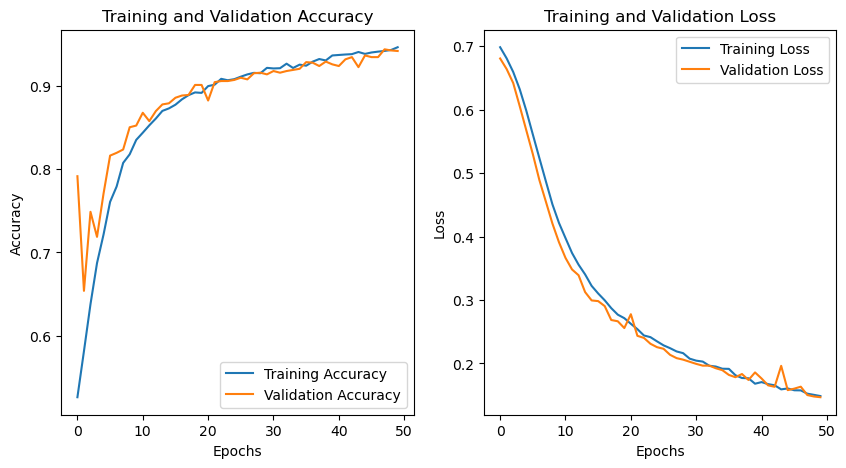

In [12]:
plt.figure(figsize=(10, 5))

# 訓練與驗證準確率
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 訓練與驗證損失
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
# 評估模型
# Accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {test_accuracy * 100:.2f}%")

# F1-Score
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test, axis=1)


precision = precision_score(y_true_class, y_pred_class, average='weighted')
recall = recall_score(y_true_class, y_pred_class, average='weighted')
f1 = f1_score(y_true_class, y_pred_class)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9497 - loss: 0.1278
Accuracy: 95.07%
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precision: 95.07%
Recall: 95.07%
Test F1-score: 0.95
